In [1]:
# General Dependencies
import numpy as np
#import scipy.io as io
from skimage import io

# Preprocessing Dependencies
from trefide.utils.noise import estimate_noise

# Plotting & Video Dependencies
import matplotlib.pyplot as plt
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imshow

%load_ext autoreload
%autoreload 2

In [2]:
def play(movie, gain=3, fr=120, offset=0, magnification=3):
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(350, 1000):
            if magnification != 1:
                frame = cv2.resize(movie[:,:,t],
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

In [3]:
mov = io.imread('/home/ian/devel/cocaim/example_movies/demoMovie.tif').transpose([1,2,0])
d1, d2, T = mov.shape

In [4]:
play(mov)

In [5]:
X = (mov.reshape((d1*d2), T) / estimate_noise(mov.reshape((d1*d2), T), summarize="mean")[:, None]).reshape(d1,d2,T).copy()

In [6]:
play(X)

In [16]:
max_components = 50
maxiter=50
tol = 5e-3
bheight = 30
bwidth = 40
spatial_cutoff = (bheight*bwidth / ((bheight*(bwidth-1) + bwidth*(bheight-1)))) #.1#.0085#
w=.0025

In [17]:
U, V, K, indices = blockwise_pmd(d1, d2, T, X.astype(np.float64), bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

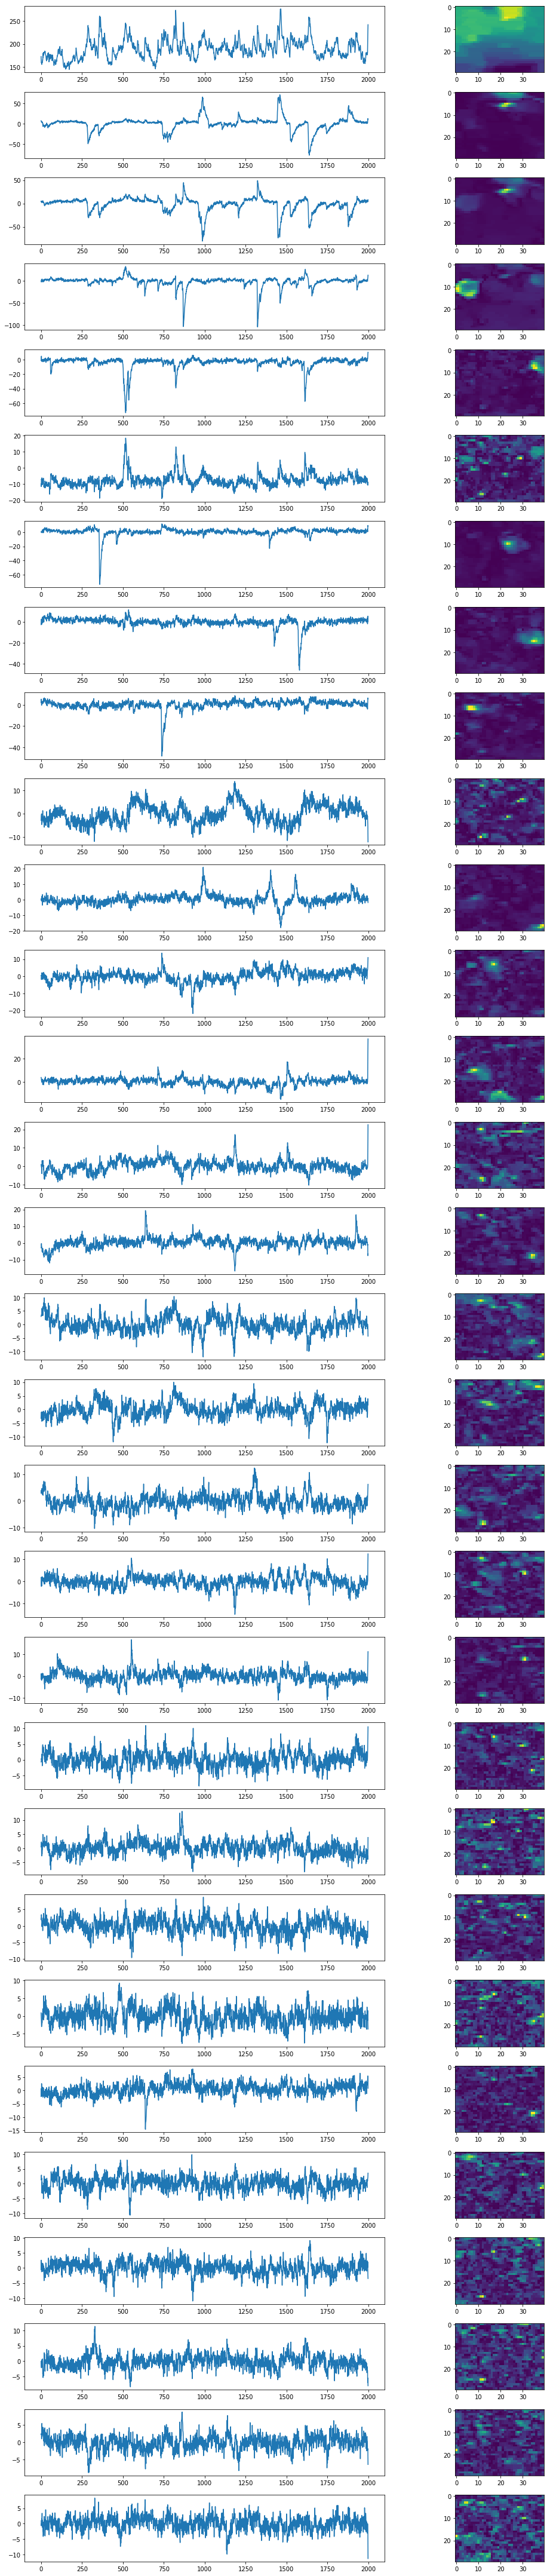

In [18]:
b_idx = -1
fig, ax = plt.subplots(int(K[b_idx]), 2, figsize=(16, 2*int(K[b_idx])))
for k in range(int(K[b_idx])):
    ax[k,0].plot(np.arange(T), V[b_idx, k, :])
    ax[k,1].imshow(np.abs(U[b_idx,:,:,k]))
    #ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    #ax[k,1].set_title("Spatial component {}, Passed: {}".format(k,k < K_prev[b_idx]))
plt.tight_layout()
plt.show()

In [19]:
K

array([28, 20, 31, 30], dtype=uint64)

In [20]:
np.sum(K)

109

In [21]:
reconstructed = np.zeros(np.prod(X.shape)).reshape(X.shape)
for b_idx, num_components in enumerate(K):
    for k in range(num_components):
        idx, jdx = indices[b_idx]
        idx *= bheight
        jdx *= bwidth
        reconstructed[idx:idx+bheight, jdx:jdx+bwidth] += U[b_idx,:,:,k][:,:,None].dot(V[b_idx,k,:][None,:]).reshape((bheight,bwidth,T), order='F')

In [22]:
play(np.vstack([X, reconstructed, np.abs(X - reconstructed)]), magnification=4, gain=2)

In [15]:
play(np.vstack([np.abs(X - reconstructed)]), magnification=2)